In [5]:
import os
import pandas as pd

project_root = r"C:\Users\Diya\OneDrive\Desktop\quant-trading-system"
path = os.path.join(project_root, "results", "backtest_trades.csv")

df = pd.read_csv(path)
print(df.columns)


Index(['Date', 'open', 'high', 'low', 'close', 'EMA_50', 'EMA_200', 'EMA_5',
       'EMA_15', 'returns', 'regime_label', 'signal', 'position',
       'strategy_returns', 'cumulative_returns', 'cumulative_market',
       'trade_return', 'target'],
      dtype='object')


In [39]:
import pandas as pd
import os

path = r"C:\Users\Diya\OneDrive\Desktop\quant-trading-system\results\backtest_trades.csv"

df = pd.read_csv(path, parse_dates=["Date"])
df.head()


,Date,open,high,low,close,EMA_50,EMA_200,EMA_5,EMA_15,returns,regime_label,signal,position,strategy_returns,cumulative_returns,cumulative_market,trade_return,target
0,2025-10-27 09:20:00+05:30,25862.849609,25882.900391,25862.849609,25880.949219,25862.167011,25861.594906,25867.916667,25863.843994,0.000756,-1,1,1,0.0,1.000000,1.000756,-0.0,0
1,2025-10-27 12:40:00+05:30,25977.250000,25980.699219,25969.800781,25974.300781,25948.792186,25895.802621,25977.757132,25977.873043,-0.000140,-1,-1,-1,-0.0,1.000313,1.004366,-0.0,0
2,2025-10-27 15:10:00+05:30,25970.199219,25970.650391,25961.699219,25963.800781,25955.599238,25911.999125,25960.238602,25959.715489,-0.000196,-1,1,1,-0.0,1.000683,1.003960,0.0,0
3,2025-10-28 15:00:00+05:30,25852.699219,25921.150391,25852.699219,25920.150391,25884.545074,25928.417009,25865.305140,25860.930459,0.002690,-1,1,1,0.0,1.000847,1.002272,0.0,0
4,2025-10-29 15:20:00+05:30,26054.900391,26070.699219,26050.800781,26065.949219,26048.451201,26005.333634,26052.876221,26051.866573,0.000447,-1,1,1,0.0,1.000796,1.007909,-0.0,0


In [41]:
import numpy as np

q1 = df["trade_return"].quantile(0.25)
q3 = df["trade_return"].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers = df[(df["trade_return"] < lower) | (df["trade_return"] > upper)]
print("Outliers:", len(outliers))


Outliers: 8


In [43]:
q1 = df["strategy_returns"].quantile(0.25)
q3 = df["strategy_returns"].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers = df[(df["strategy_returns"] < lower) | (df["strategy_returns"] > upper)]
print("Outliers:", len(outliers))


Outliers: 7


In [45]:
# Notebook 7: Outlier Analysis (High Performance Trade Analysis)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ----------------------------
# 1. Load trades
# ----------------------------
trades = pd.read_csv("results/backtest_trades.csv")

# Ensure datetime parsing
trades["entry_time"] = pd.to_datetime(trades["entry_time"], errors='coerce')
trades["exit_time"] = pd.to_datetime(trades["exit_time"], errors='coerce')

# ----------------------------
# 2. Clean and prepare
# ----------------------------
trades.dropna(subset=["entry_time", "exit_time"], inplace=True)

# Trade duration in minutes
trades["duration"] = (trades["exit_time"] - trades["entry_time"]).dt.total_seconds() / 60

# Make sure pnl exists
if "pnl" not in trades.columns:
    trades["pnl"] = trades["exit_price"] - trades["entry_price"]

# ----------------------------
# 3. Outlier Detection (3-sigma)
# ----------------------------
profit_trades = trades[trades["pnl"] > 0].copy()

mean_pnl = profit_trades["pnl"].mean()
std_pnl = profit_trades["pnl"].std()

profit_trades["z_score"] = (profit_trades["pnl"] - mean_pnl) / std_pnl
profit_trades["is_outlier"] = profit_trades["z_score"].abs() > 3

# ----------------------------
# 4. Compare outlier vs normal
# ----------------------------
outliers = profit_trades[profit_trades["is_outlier"]]
normal = profit_trades[~profit_trades["is_outlier"]]

# Stats
summary = pd.DataFrame({
    "count": [len(outliers), len(normal)],
    "avg_pnl": [outliers["pnl"].mean(), normal["pnl"].mean()],
    "avg_duration": [outliers["duration"].mean(), normal["duration"].mean()]
}, index=["outliers", "normal"])

print(summary)

# ----------------------------
# 5. Visualizations
# ----------------------------

# Scatter plot (PnL vs duration)
plt.figure(figsize=(10,6))
plt.scatter(profit_trades["duration"], profit_trades["pnl"], alpha=0.5)
plt.title("PnL vs Trade Duration")
plt.xlabel("Duration (minutes)")
plt.ylabel("PnL")
plt.show()

# Boxplots
features = ["pnl", "duration"]
plt.figure(figsize=(12,5))
sns.boxplot(data=profit_trades, x="is_outlier", y="pnl")
plt.title("PnL Distribution: Outlier vs Normal")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(data=profit_trades, x="is_outlier", y="duration")
plt.title("Duration Distribution: Outlier vs Normal")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,8))
corr = profit_trades[["pnl", "duration", "entry_price", "exit_price"]].corr()
sns.heatmap(corr, annot=True)
plt.title("Correlation Heatmap")
plt.show()

# Time distribution
profit_trades["entry_hour"] = profit_trades["entry_time"].dt.hour
plt.figure(figsize=(12,5))
sns.histplot(profit_trades, x="entry_hour", hue="is_outlier", bins=24, kde=False)
plt.title("Entry Time Distribution (Outlier vs Normal)")
plt.show()

# ----------------------------
# 6. Statistical comparison
# ----------------------------
t_test = stats.ttest_ind(outliers["pnl"], normal["pnl"], equal_var=False)
print("T-test for PnL difference:", t_test)

# ----------------------------
# 7. Insights Summary
# ----------------------------
insights = {
    "outlier_percentage": len(outliers) / len(profit_trades) * 100,
    "avg_pnl_outlier": outliers["pnl"].mean(),
    "avg_pnl_normal": normal["pnl"].mean(),
    "avg_duration_outlier": outliers["duration"].mean(),
    "avg_duration_normal": normal["duration"].mean(),
    "time_pattern_outliers": outliers["entry_hour"].mode().tolist(),
    "time_pattern_normal": normal["entry_hour"].mode().tolist(),
}

print("\nInsights Summary:")
for k, v in insights.items():
    print(f"{k}: {v}")



FileNotFoundError: [Errno 2] No such file or directory: 'results/backtest_trades.csv'

In [47]:
import os
print(os.getcwd())


C:\Users\Diya\OneDrive\Desktop\quant-trading-system\notebooks


C:\Users\Diya\AppData\Local\Temp\ipykernel_24652\3866377209.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades["z_score"] = np.abs(zscore(trades["trade_return"]))


Total Trades: 319
Outliers: 7
Outlier %: 2.19 %
Avg PnL (Outliers): 0.008403
Avg PnL (Normal): -0.000219


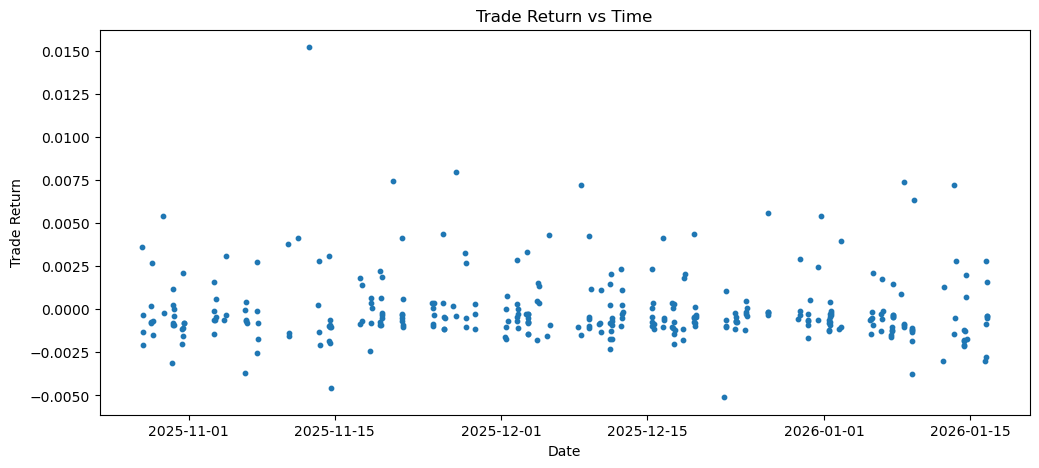

C:\Users\Diya\AppData\Local\Temp\ipykernel_24652\3866377209.py:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([normal_trades["trade_return"], outliers["trade_return"]],


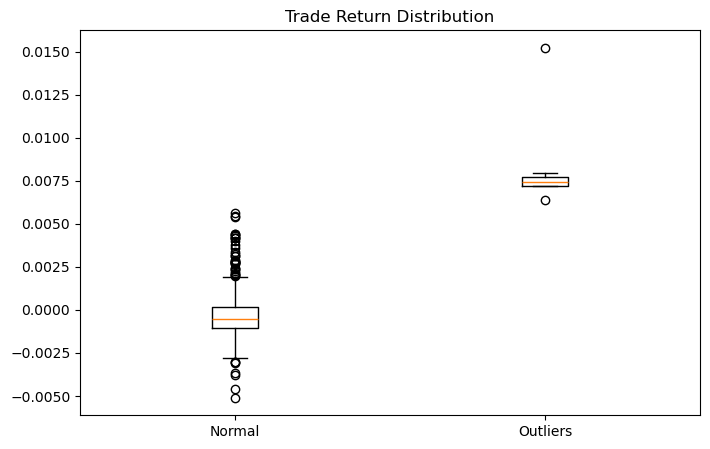

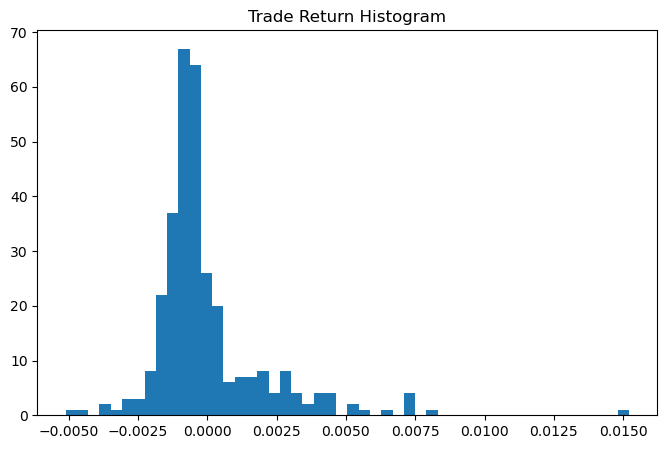

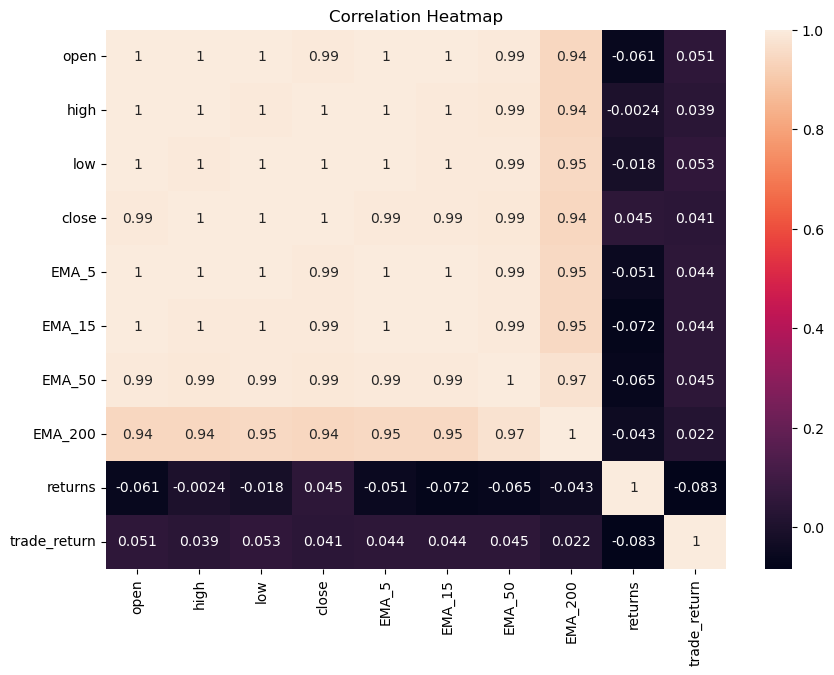


Statistical Test Results (Outliers vs Normal):
returns -> p-value: 0.87651
EMA_5 -> p-value: 0.85044
EMA_15 -> p-value: 0.83457
EMA_50 -> p-value: 0.95958
EMA_200 -> p-value: 0.76249

Saved outlier and normal trades successfully.


In [55]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, mannwhitneyu

# -------------------------
# 1. Load data
# -------------------------
project_root = r"C:\Users\Diya\OneDrive\Desktop\quant-trading-system"
path = os.path.join(project_root, "data", "features", "nifty_features_spot_5min.csv")

df = pd.read_csv(path, parse_dates=["Date"])

# -------------------------
# 2. Create signal & position if missing
# -------------------------

# If signal is missing, create it using EMA crossover
if "signal" not in df.columns:
    df["signal"] = 0
    df.loc[(df["EMA_5"] > df["EMA_15"]) & (df["EMA_5"].shift(1) <= df["EMA_15"].shift(1)), "signal"] = 1
    df.loc[(df["EMA_5"] < df["EMA_15"]) & (df["EMA_5"].shift(1) >= df["EMA_15"].shift(1)), "signal"] = -1

# Create position from signal
df["position"] = df["signal"].replace(0, np.nan).ffill().fillna(0)

# -------------------------
# 3. Create trade_return
# -------------------------
df["trade_return"] = 0.0

entries = df[df["position"].diff() != 0].index

for i in range(len(entries)-1):
    start = entries[i]
    end = entries[i+1]
    
    entry_price = df.loc[start, "close"]
    exit_price = df.loc[end, "close"]
    pos = df.loc[start, "position"]
    
    df.loc[end, "trade_return"] = (exit_price - entry_price) / entry_price * pos

trades = df[df["trade_return"] != 0]

# -------------------------
# 4. Outlier Detection
# -------------------------
trades["z_score"] = np.abs(zscore(trades["trade_return"]))

outliers = trades[trades["z_score"] > 3]
normal_trades = trades[trades["z_score"] <= 3]

# -------------------------
# 5. Insights
# -------------------------
outlier_percent = (len(outliers) / len(trades)) * 100
avg_outlier_pnl = outliers["trade_return"].mean()
avg_normal_pnl = normal_trades["trade_return"].mean()

print("Total Trades:", len(trades))
print("Outliers:", len(outliers))
print("Outlier %:", round(outlier_percent, 2), "%")
print("Avg PnL (Outliers):", round(avg_outlier_pnl, 6))
print("Avg PnL (Normal):", round(avg_normal_pnl, 6))

# -------------------------
# 6. Visualizations
# -------------------------
plt.figure(figsize=(12,5))
plt.scatter(trades["Date"], trades["trade_return"], s=10)
plt.title("Trade Return vs Time")
plt.xlabel("Date")
plt.ylabel("Trade Return")
plt.show()

plt.figure(figsize=(8,5))
plt.boxplot([normal_trades["trade_return"], outliers["trade_return"]],
            labels=["Normal", "Outliers"])
plt.title("Trade Return Distribution")
plt.show()

plt.figure(figsize=(8,5))
plt.hist(trades["trade_return"], bins=50)
plt.title("Trade Return Histogram")
plt.show()

# -------------------------
# 7. Correlation Heatmap
# -------------------------
corr_cols = ["open", "high", "low", "close", "EMA_5", "EMA_15", "EMA_50", "EMA_200", "returns", "trade_return"]
corr = trades[corr_cols].corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True)
plt.title("Correlation Heatmap")
plt.show()

# -------------------------
# 8. Statistical Test
# -------------------------
features = ["returns", "EMA_5", "EMA_15", "EMA_50", "EMA_200"]

print("\nStatistical Test Results (Outliers vs Normal):")
for f in features:
    stat, p = mannwhitneyu(outliers[f], normal_trades[f], alternative="two-sided")
    print(f"{f} -> p-value: {round(p, 5)}")

# -------------------------
# 9. Save outputs
# -------------------------
outliers.to_csv(os.path.join(project_root, "results", "outlier_trades.csv"), index=False)
normal_trades.to_csv(os.path.join(project_root, "results", "normal_trades.csv"), index=False)

print("\nSaved outlier and normal trades successfully.")
